# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "soufiane"
ln1 = "moutei"
fn2 = "mohammed"
ln2 = "barrahma-tlemcani"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_moutei_soufiane_and_barrahma-tlemcani_mohammed.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

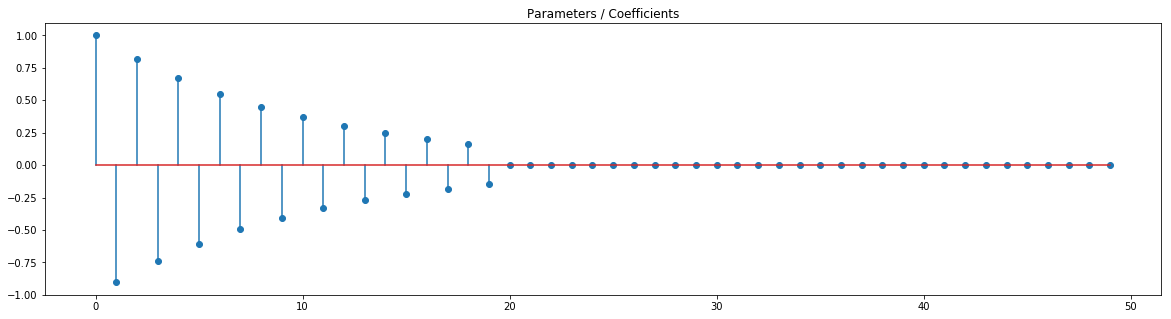

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.figure(figsize=(20,5))
plt.stem(coefs)
plt.title("Parameters / Coefficients");

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [6]:
from numpy.linalg import norm

def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(x) * np.maximum(np.abs(x) - s, 0) 

    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * norm(x, ord=1)

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""    
    return x / (s + 1)
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return (s / 2) * (norm(x) ** 2)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

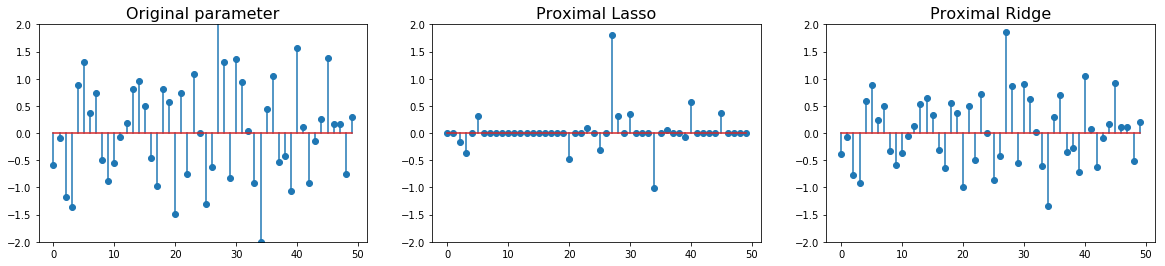

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(20.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2]);

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER</span>
     <ul>
    <li>We can see that the <b>Proximal Lasso</b> tends to penalize weights by making them close to $0$. In fact, weights with a value higher than $s$ ($s = 1$ in our case) will decrease by $s$, weights with a value lower than $- s$ will increase by $s$ and those with an absolute value lower than $s$ will be set to zero.</li>
    <li>The <b>Proximal Ridge</b> will attempt to make weights as small as possible by shrinking them using the factor $ \frac{1}{1 + s} $ (which is equal to $ \frac{1}{1.5} \simeq 0.67) $.</li>
    </ul>
</div>

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [8]:
def create_loss_linreg(coefs, n_samples=1000, corr=0.5):
    """
    Simulation of a linear regression model and create the corresponding functions
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    loss_linreg : `function`
        A function to work out the linear regression loss
    
    grad_linreg : `function`
        A function to work out the gradient of the linear regression loss
        
    
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix.
    """
    
    A, b = simu_linreg(coefs, n_samples, corr)
    n = len(b)
    
    def loss_linreg(x):
        """Least-squares loss"""
        return ((norm(b - A.dot(x))) ** 2) / (2 * n)
    
    def grad_linreg(x):
        """Least-squares gradient"""
        return (1 / n) * A.T.dot(A.dot(x) - b)
    
    return loss_linreg, grad_linreg, A

def create_loss_logreg(coefs, n_samples=1000, corr=0.5):
    """
    Simulation of a logistic regression model and create the corresponding functions
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    loss_logreg : `function`
        A function to work out the logistic regression loss
    
    grad_logreg : `function`
        A function to work out the gradient of the logistic regression loss
        
    
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix.
    """
    
    A, b = simu_logreg(coefs, n_samples, corr)
    n = len(b)
    
    def loss_logreg(x):
        """Logistic loss"""
        return (1 / n) * np.sum(np.log(1 + np.exp(- b * A.dot(x))))
    
    def grad_logreg(x):
        """Logistic gradient"""
        f = 0
        for i in range(n):
            f += - (b[i] * A[i]) / (1 + np.exp(b[i] * A[i].T.dot(x)))
        return f / n
    
    return loss_logreg, grad_logreg, A

In [9]:
loss_linreg, grad_linreg, _ = create_loss_linreg(coefs)
loss_logreg, grad_logreg, _ = create_loss_logreg(coefs)

In [10]:
from scipy.optimize import check_grad

print("The correctness of the gradient function of linear regression: ", check_grad(loss_linreg, grad_linreg, x))
print("The correctness of the gradient function of logistic regression: ", check_grad(loss_logreg, grad_logreg, x))

The correctness of the gradient function of linear regression:  2.0145682917571446e-06
The correctness of the gradient function of logistic regression:  1.9813671487564846e-07


<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">COMMENT</span><br><br>

    We obtained a very low error which means that our implementation of the gradients was correct.
</div>

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [11]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return (norm(A, ord=2) ** 2) / A.shape[0]
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return (norm(A, ord=2) ** 2) / (4 * A.shape[0])
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """
    Proximal gradient descent algorithm
    
    
    Parameters
    ----------
    x0 : `numpy.array`, shape (n_features,)
        Initialization value
    
    f : `function`
        The loss function
    
    grad_f : `function`
        The gradient of the loss function
        
    g : `function`
        The regularization function
    
    prox_g : `function`
        The proximal operator of the regularization function
        
    step: `float`
        The update step
    
    s: `float`, default=0
        The regularization parameter
    
    n_iter: `int`, default=50
        The number of iterations
        
    x_true: `numpy.array`, shape (n_features,), default=coefs
        The true value we attempt to converge to
        
    verbose : `bool`, default=True
        Shows or hides the loggings

    Returns
    -------
    x : `numpy.array`, shape (n_features,)
        The value that x0 converged to
    
    objectives : `list`
        A list containing the tracks on the objective function over iterations
        
    errors : `list`
        A list containing the tracks on the error over iterations
    """
    
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - step * grad_f(x), s * step) # Update formula
                
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [12]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """
    Accelerated Proximal gradient descent algorithm
    
    Parameters
    ----------
    x0 : `numpy.array`, shape (n_features,)
        Initialization value
    
    f : `function`
        The loss function
    
    grad_f : `function`
        The gradient of the loss function
        
    g : `function`
        The regularization function
    
    prox_g : `function`
        The proximal operator of the regularization function
        
    step: `float`
        The update step
    
    s: `float`, default=0
        The regularization parameter
    
    n_iter: `int`, default=50
        The number of iterations
        
    x_true: `numpy.array`, shape (n_features,), default=coefs
        The true value we attempt to converge to
        
    verbose : `bool`, default=True
        Shows or hides the loggings

    Returns
    -------
    x : `numpy.array`, shape (n_features,)
        The value that x0 converged to
    
    objectives : `numpy.array`, shape (n_iter,)
        A list containing the tracks on the objective function over iterations
        
    errors : `numpy.array`, shape (n_iter,)
        A list containing the tracks on the error over iterations
    """
    
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        # Update  formulas
        x_new = prox_g(z - step * grad_f(z), s * step)
        t_new = (1 + np.sqrt(1 + 4 * (t ** 2))) / 2
        z = x_new + ((t - 1) / t_new) * (x_new - x)
                
        x = x_new.copy()
        t = t_new
        # End of updating formulas
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    </ul>
</div>

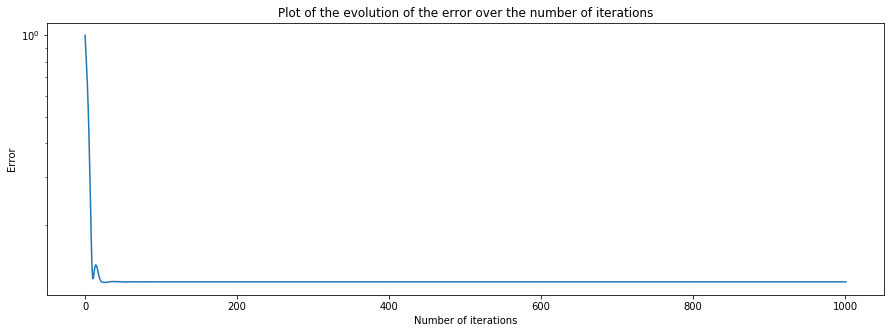

In [13]:
loss_linreg, grad_linreg, A = create_loss_linreg(coefs)
L = lip_linreg(A)

# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
s = 1e-2

x, objectives, errors = fista(
    x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1 / L, s, n_iter, verbose=False
)

plt.figure(figsize=(15,5))
plt.semilogy(errors)
plt.title("Plot of the evolution of the error over the number of iterations")
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.show()

In [14]:
# Compute a precise minimum and a precise minimizer
minimum = objectives[-1]
minimizer = x.copy()

print("* The minimum is: ", minimum)
print("* The minimizer is: ", minimizer)

* The minimum is:  0.5269196263314881
* The minimizer is:  [ 9.93e-01 -9.15e-01  8.82e-01 -7.70e-01  6.57e-01 -5.82e-01  5.56e-01
 -5.17e-01  4.65e-01 -4.02e-01  3.23e-01 -2.88e-01  2.87e-01 -2.47e-01
  1.85e-01 -1.92e-01  1.56e-01 -2.36e-01  2.34e-01 -1.78e-01  5.76e-02
 -7.09e-02 -9.23e-03  2.21e-02 -1.00e-01  1.04e-01 -6.92e-02  6.88e-02
 -6.48e-02 -3.40e-02  2.61e-02  4.66e-02  1.64e-02 -5.23e-02  1.72e-04
 -1.67e-02 -3.11e-02  7.37e-04 -2.31e-03  1.38e-02  1.11e-02  4.87e-02
 -1.31e-02  3.57e-03 -8.71e-03 -1.91e-03  3.20e-02 -2.83e-02  2.95e-03
 -1.76e-03]


<div class="alert alert-info">
    <span class="label label-primary" style="font-size:15px;">ANSWER</span>
     <ul>
    <li>The minimum is the last value of the objective which the algorithm converged to.</li>
    <li>The minimizer is the last value we got of `x`.</li>
    </ul>
</div>

<div class="alert alert-success">
     <ul>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

<div class="alert alert-warning">
    We got in the last question the value of the minimizer that was gotten using `FISTA` and a dummy `x_true` parameter value. Now, in order to compute the convergence of our two algorithms to the minimizer we got, we will run them using this minimizer as `x_true` parameter value.
</div>

In [15]:
loss_linreg, grad_linreg, A = create_loss_linreg(minimizer)
L = lip_linreg(A)

x, objectives, errors = fista(
    x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1 / L, s, 100, x_true=minimizer, verbose=False
)

x_ista, objectives_ista, errors_ista = ista(
    x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1 / L, s, 100, x_true=minimizer, verbose=False
)

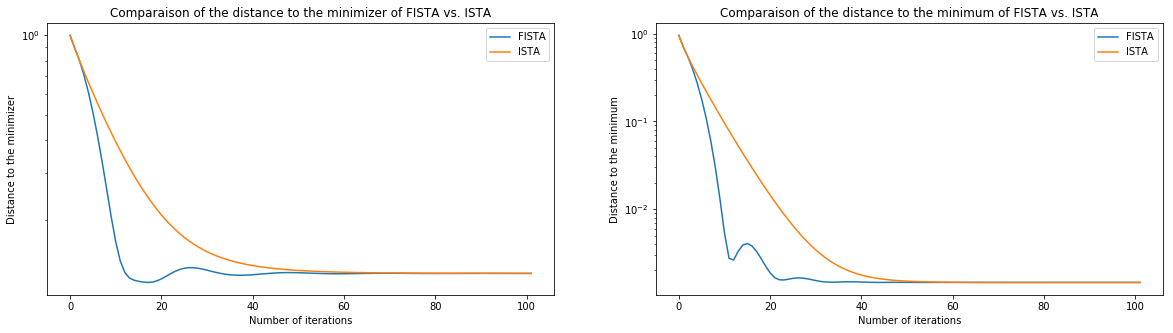

In [16]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.semilogy(errors)
plt.semilogy(errors_ista)
plt.legend(["FISTA", "ISTA"])
plt.title("Comparaison of the distance to the minimizer of FISTA vs. ISTA")
plt.xlabel("Number of iterations")
plt.ylabel("Distance to the minimizer")

plt.subplot(1, 2, 2)
plt.semilogy(objectives - minimum)
plt.semilogy(objectives_ista - minimum)
plt.legend(["FISTA", "ISTA"])
plt.title("Comparaison of the distance to the minimum of FISTA vs. ISTA")
plt.xlabel("Number of iterations")
plt.ylabel("Distance to the minimum")
plt.show()

<div class="alert alert-info">
    <span class="label label-primary" style="font-size:15px;">ANSWER</span><br><br>
     We can see that `FISTA` has a faster convergence speed in terms of both the distance to the minimizer and the distance to the minimum than `ISTA`. That's can be explained given Beck Teboulle theorem, the convergence of objective function is upper-bounded by $O(\frac{1}{T^2})$ for `FISTA` whereas it is upper-bounded by $O(\frac{1}{T})$ for `ISTA`. Therefore, `ISTA` needs more steps than `FISTA` to achieve the latter's results.
</div>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    </ul>
</div>

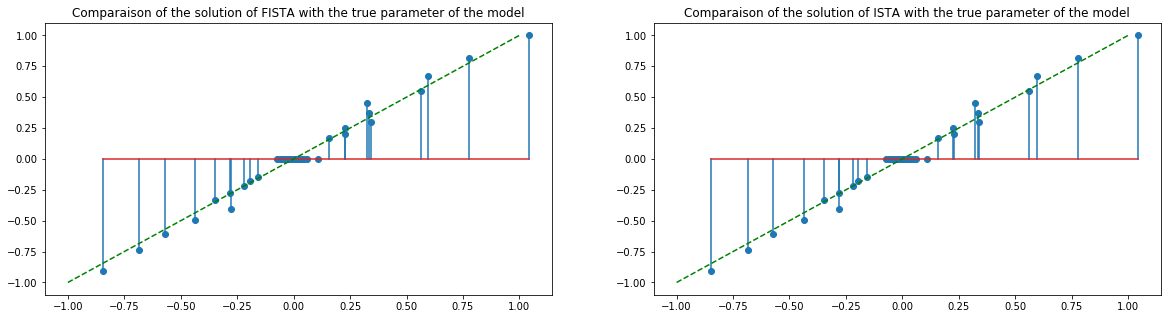

In [17]:
loss_linreg, grad_linreg, A = create_loss_linreg(coefs)
L = lip_linreg(A)

x, _, _ = fista(
    x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1 / L, s, n_iter, verbose=False
)

x_ista, _, _ = ista(
    x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1 / L, s, n_iter, verbose=False
)

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.title("Comparaison of the solution of FISTA with the true parameter of the model")
plt.stem(x, coefs)
plt.plot(np.arange(-1, 2), np.arange(-1, 2), "g--")

plt.subplot(1, 2, 2)
plt.title("Comparaison of the solution of ISTA with the true parameter of the model")
plt.stem(x_ista, coefs)
plt.plot(np.arange(-1, 2), np.arange(-1, 2), "g--");

<div class="alert alert-info">
    <span class="label label-primary" style="font-size:15px;">ANSWER</span><br><br>
    
    We plotted in addition the linear equation $y=x$. We can see that the points $(x,y)$ plotted by `plt.stem` are very close for both algorithms to this linear equation. This means that both `ISTA` and `FISTA` converge to the true parameter `coefs`.
</div>

<div class="alert alert-success">
     <ul>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    </ul>
</div>

In [18]:
def perfom_ista_and_fista(coefs, create_loss, lip, g, prox_g, s=1e-2, n_iter=100, corr=0.5, verbose=True):
    """A function to perfom ISTA and FISTA for the given parameters and returns the errors"""
    
    global loss, grad, A, L
    
    # In case we don't want to re-define the parameters for each execution
    if (create_loss is not None):
        loss, grad, A = create_loss(coefs, corr=corr)
        L = lip(A)
    
    if (verbose):
        print("* Lipschitz constant for correlation = ", corr, ":", L)
    
    _, _, errors = fista(
        x0, loss, grad, g, prox_g, 1 / L, s, n_iter, verbose=False
    )
    _, _, errors_ista = ista(
        x0, loss, grad, g, prox_g, 1 / L, s, n_iter, verbose=False
    )
    
    return errors, errors_ista

-- Running Linear Regression --
* Lipschitz constant for correlation =  0.2 : 1.7733471470224322
* Lipschitz constant for correlation =  0.5 : 3.286423654513162
* Lipschitz constant for correlation =  0.8 : 8.262415865109308
-- Running Logistic Regression --
* Lipschitz constant for correlation =  0.2 : 0.45736319983668683
* Lipschitz constant for correlation =  0.5 : 0.8244581635540148
* Lipschitz constant for correlation =  0.8 : 2.1270146462903696


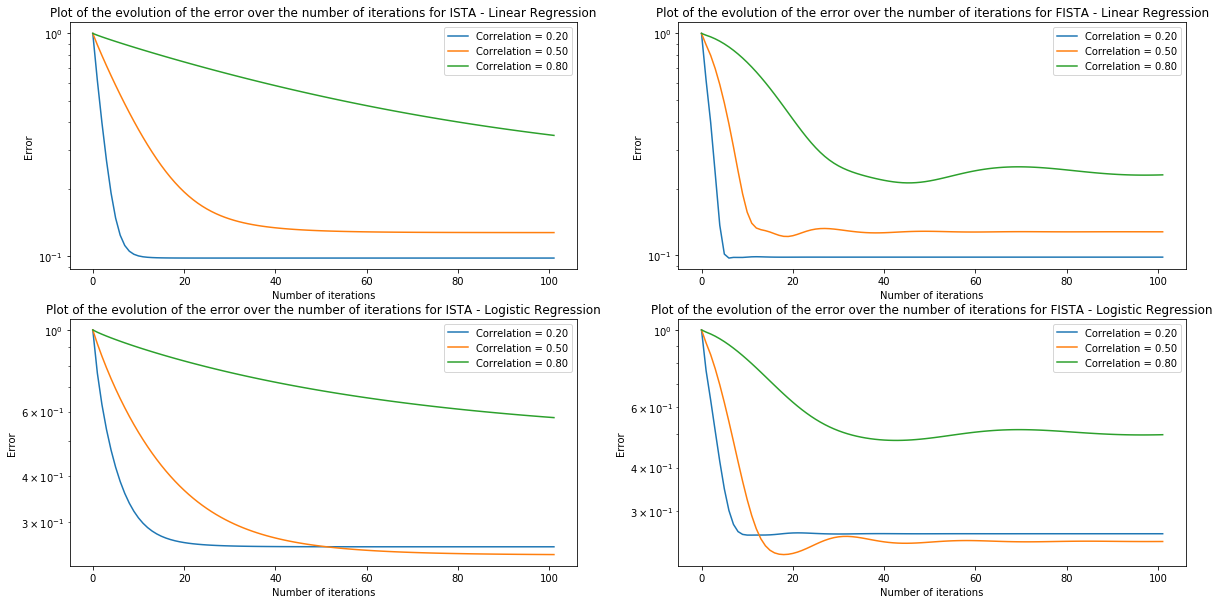

In [19]:
errors_dict = {"Linear": {"ISTA": {}, "FISTA": {}}, "Logistic": {"ISTA": {}, "FISTA": {}}}

print("-- Running Linear Regression --")
errors_dict["Linear"]["FISTA"]["0.20"], errors_dict["Linear"]["ISTA"]["0.20"] = (
    perfom_ista_and_fista(coefs, create_loss_linreg, lip_linreg, ridge, prox_ridge, corr=0.2)
)
errors_dict["Linear"]["FISTA"]["0.50"], errors_dict["Linear"]["ISTA"]["0.50"] = (
    perfom_ista_and_fista(coefs, create_loss_linreg, lip_linreg, ridge, prox_ridge, corr=0.5)
)
errors_dict["Linear"]["FISTA"]["0.80"], errors_dict["Linear"]["ISTA"]["0.80"] = (
    perfom_ista_and_fista(coefs, create_loss_linreg, lip_linreg, ridge, prox_ridge, corr=0.8)
)

print("-- Running Logistic Regression --")
errors_dict["Logistic"]["FISTA"]["0.20"], errors_dict["Logistic"]["ISTA"]["0.20"] = (
    perfom_ista_and_fista(coefs, create_loss_logreg, lip_logreg, ridge, prox_ridge, corr=0.2)
)
errors_dict["Logistic"]["FISTA"]["0.50"], errors_dict["Logistic"]["ISTA"]["0.50"] = (
    perfom_ista_and_fista(coefs, create_loss_logreg, lip_logreg, ridge, prox_ridge, corr=0.5)
)
errors_dict["Logistic"]["FISTA"]["0.80"], errors_dict["Logistic"]["ISTA"]["0.80"] = (
    perfom_ista_and_fista(coefs, create_loss_logreg, lip_logreg, ridge, prox_ridge, corr=0.8)
)

plt.figure(figsize=(20,10))
i = 1
for regression_type in errors_dict:
    for algorithm_name in errors_dict[regression_type]:
        plt.subplot(2, 2, i)
        for t in errors_dict[regression_type][algorithm_name]:
            plt.semilogy(errors_dict[regression_type][algorithm_name][t], label="Correlation = " + t)
        
        plt.title(
            "Plot of the evolution of the error over the number of iterations for " + algorithm_name + " - "+ regression_type + " Regression"
        )
        plt.legend()
        plt.xlabel("Number of iterations")
        plt.ylabel("Error")
        i += 1

<div class="alert alert-info">
    <span class="label label-primary" style="font-size:15px;">ANSWER</span><br><br>
     We can see that as long as the correlation gets higher, the Lipschitz constant increases (and significantly if the correlation is close to $1$). So, the steps value is low for high correlations and as a consequence we have a small update, hence the slowness of the convergence for high correlations. On the other hand, given Beck Teboulle theorem, the convergence of objective function is upper-bounded by $L$ which means that are more steps are needed for high correlations and fewer for low correlations. Besides, FISTA is faster than ISTA in all cases.
</div>

<div class="alert alert-success">
     <ul>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    </ul>
</div>

-- Running Linear Regression --
-- Running Logistic Regression --


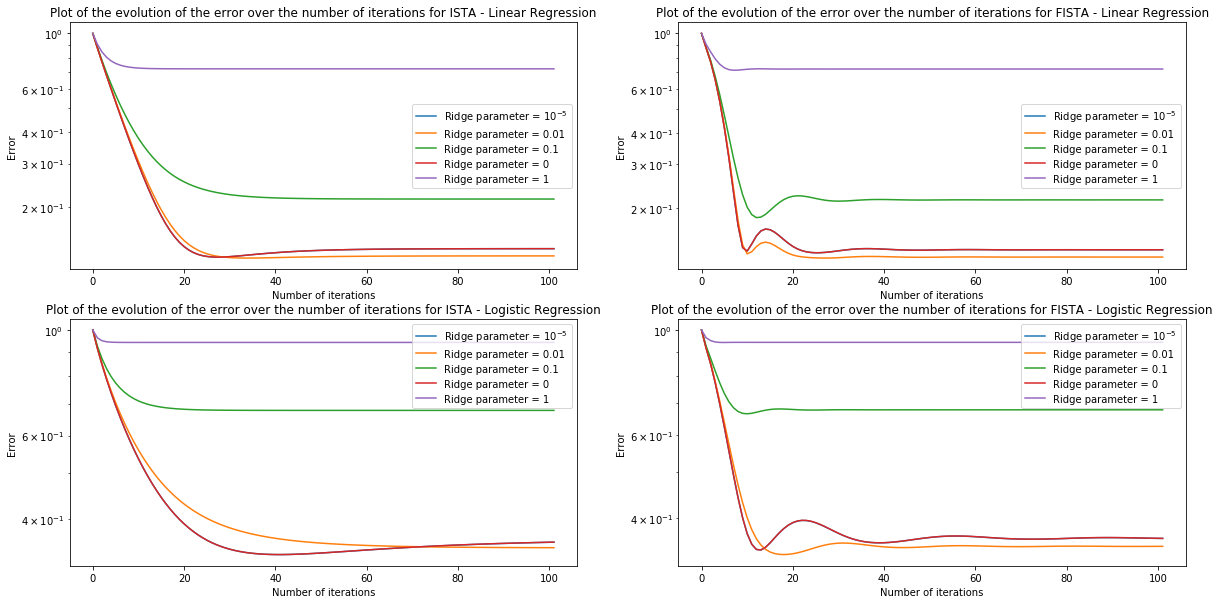

In [20]:
errors_dict = {"Linear": {"ISTA": {}, "FISTA": {}}, "Logistic": {"ISTA": {}, "FISTA": {}}}

print("-- Running Linear Regression --")
loss, grad, A = create_loss_linreg(coefs)
L = lip_linreg(A)

errors_dict["Linear"]["FISTA"]["$10^{-5}$"], errors_dict["Linear"]["ISTA"]["$10^{-5}$"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=1e-5, verbose=False)
)
errors_dict["Linear"]["FISTA"]["0.01"], errors_dict["Linear"]["ISTA"]["0.01"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=1e-2, verbose=False)
)
errors_dict["Linear"]["FISTA"]["0.1"], errors_dict["Linear"]["ISTA"]["0.1"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=.1, verbose=False)
)
errors_dict["Linear"]["FISTA"]["0"], errors_dict["Linear"]["ISTA"]["0"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=0, verbose=False)
)
errors_dict["Linear"]["FISTA"]["1"], errors_dict["Linear"]["ISTA"]["1"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=1, verbose=False)
)

print("-- Running Logistic Regression --")
loss, grad, A = create_loss_logreg(coefs)
L = lip_logreg(A)

errors_dict["Logistic"]["FISTA"]["$10^{-5}$"], errors_dict["Logistic"]["ISTA"]["$10^{-5}$"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=1e-5, verbose=False)
)
errors_dict["Logistic"]["FISTA"]["0.01"], errors_dict["Logistic"]["ISTA"]["0.01"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=1e-2, verbose=False)
)
errors_dict["Logistic"]["FISTA"]["0.1"], errors_dict["Logistic"]["ISTA"]["0.1"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=.1, verbose=False)
)
errors_dict["Logistic"]["FISTA"]["0"], errors_dict["Logistic"]["ISTA"]["0"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=0, verbose=False)
)
errors_dict["Logistic"]["FISTA"]["1"], errors_dict["Logistic"]["ISTA"]["1"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, s=1, verbose=False)
)

plt.figure(figsize=(20,10))
i = 1
for regression_type in errors_dict:
    for algorithm_name in errors_dict[regression_type]:
        plt.subplot(2, 2, i)
        for t in errors_dict[regression_type][algorithm_name]:
            plt.semilogy(errors_dict[regression_type][algorithm_name][t], label="Ridge parameter = " + t)
        
        plt.title(
            "Plot of the evolution of the error over the number of iterations for " + algorithm_name + " - "+ regression_type + " Regression"
        )
        plt.legend()
        plt.xlabel("Number of iterations")
        plt.ylabel("Error")
        i += 1

<div class="alert alert-info">
    <span class="label label-primary" style="font-size:15px;">ANSWER</span><br><br>
     The convergence rate increases as long as we increase the ridge parameter. On the other hand, we know that with ridge penalization, the coefficients are shrinked by multiplying by the factor ${(1+\frac{s}{L})}^{-1}$. With $L$ fixed, higher ridge penalization parameter gives a smaller factor and thus smaller coefficients. Therefore, the error gets higher because the values get smaller and smaller (through iterations) and far from the `x_true` value. However, having a very small ridge parameter is similar to having no ridge parameter which is not our purpose (adding a penalty to control properties of the regression coefficients), the error is low but not the lowest, a ridge parameter of $0.01$ for instance gives a better results (lower error) as we can see especially with logistic regression.
</div>

<div class="alert alert-success">
     <ul>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

-- Running Linear Regression --
-- Running Logistic Regression --


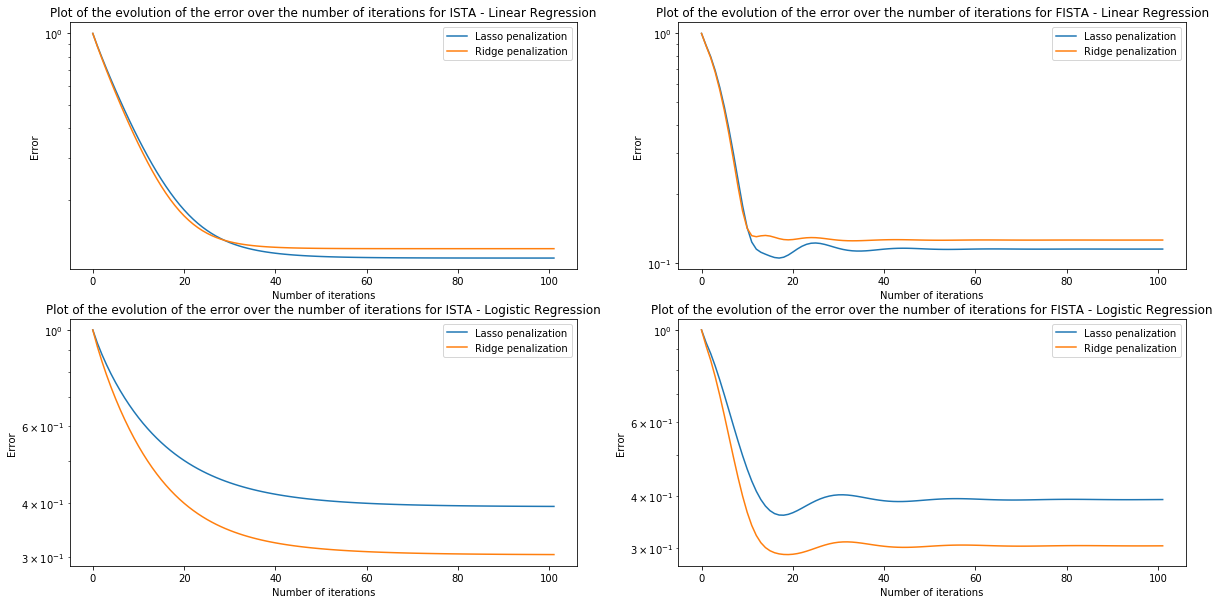

In [21]:
errors_dict = {"Linear": {"ISTA": {}, "FISTA": {}}, "Logistic": {"ISTA": {}, "FISTA": {}}}

print("-- Running Linear Regression --")
loss, grad, A = create_loss_linreg(coefs)
L = lip_linreg(A)

errors_dict["Linear"]["FISTA"]["Lasso"], errors_dict["Linear"]["ISTA"]["Lasso"] = (
    perfom_ista_and_fista(coefs, None, None, lasso, prox_lasso, verbose=False)
)
errors_dict["Linear"]["FISTA"]["Ridge"], errors_dict["Linear"]["ISTA"]["Ridge"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, verbose=False)
)

print("-- Running Logistic Regression --")
loss, grad, A = create_loss_logreg(coefs)
L = lip_logreg(A)

errors_dict["Logistic"]["FISTA"]["Lasso"], errors_dict["Logistic"]["ISTA"]["Lasso"] = (
    perfom_ista_and_fista(coefs, None, None, lasso, prox_lasso, verbose=False)
)
errors_dict["Logistic"]["FISTA"]["Ridge"], errors_dict["Logistic"]["ISTA"]["Ridge"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, verbose=False)
)

plt.figure(figsize=(20,10))
i = 1
for regression_type in errors_dict:
    for algorithm_name in errors_dict[regression_type]:
        plt.subplot(2, 2, i)
        for t in errors_dict[regression_type][algorithm_name]:
            plt.semilogy(errors_dict[regression_type][algorithm_name][t], label=t + " penalization")
        
        plt.title(
            "Plot of the evolution of the error over the number of iterations for " + algorithm_name + " - "+ regression_type + " Regression"
        )
        plt.legend()
        plt.xlabel("Number of iterations")
        plt.ylabel("Error")
        i += 1

<div class="alert alert-info">
    <span class="label label-primary" style="font-size:15px;">ANSWER</span><br><br>
     We can see that `Lasso` converges faster than `Ridge`, however it converges to a higher error value than `Ridge` for Logistic regression. For Linear regression, they are close. Given what we saw before, the difference between the two penalizations is that `Lasso` shrinks coefficients with an absolute value lower than $\frac{s}{L}$ to zero and tries to get coefficients outside this interval close to it. With a `zero initialization value` and an update step not higher enough to get coefficients outside the interval that will be shrinked to zero, we can get a higher error with `Lasso`. Whereas with `Ridge penalization`, the coefficients are only getting small and not exactly zero. This explains the behavior we got. Let's try to have a random initialization value and see the new behavior:
</div>

-- Running Linear Regression --
-- Running Logistic Regression --


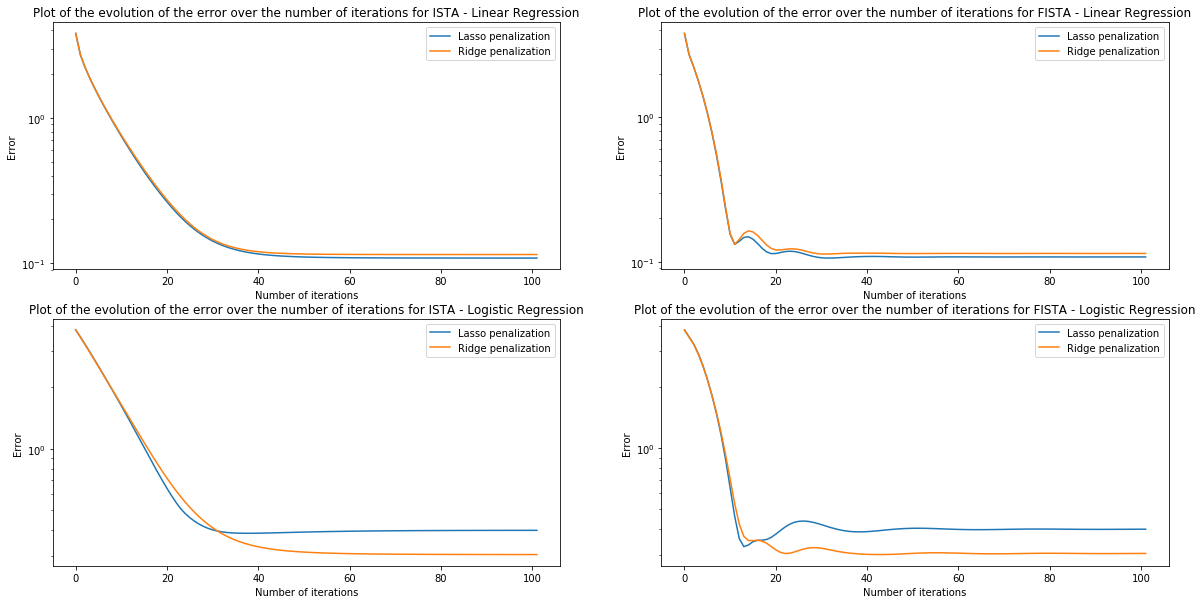

In [22]:
x0 = np.random.randint(-2, 2, n_features)

errors_dict = {"Linear": {"ISTA": {}, "FISTA": {}}, "Logistic": {"ISTA": {}, "FISTA": {}}}

print("-- Running Linear Regression --")
loss, grad, A = create_loss_linreg(coefs)
L = lip_linreg(A)

errors_dict["Linear"]["FISTA"]["Lasso"], errors_dict["Linear"]["ISTA"]["Lasso"] = (
    perfom_ista_and_fista(coefs, None, None, lasso, prox_lasso, verbose=False)
)
errors_dict["Linear"]["FISTA"]["Ridge"], errors_dict["Linear"]["ISTA"]["Ridge"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, verbose=False)
)

print("-- Running Logistic Regression --")
loss, grad, A = create_loss_logreg(coefs)
L = lip_logreg(A)

errors_dict["Logistic"]["FISTA"]["Lasso"], errors_dict["Logistic"]["ISTA"]["Lasso"] = (
    perfom_ista_and_fista(coefs, None, None, lasso, prox_lasso, verbose=False)
)
errors_dict["Logistic"]["FISTA"]["Ridge"], errors_dict["Logistic"]["ISTA"]["Ridge"] = (
    perfom_ista_and_fista(coefs, None, None, ridge, prox_ridge, verbose=False)
)

plt.figure(figsize=(20,10))
i = 1
for regression_type in errors_dict:
    for algorithm_name in errors_dict[regression_type]:
        plt.subplot(2, 2, i)
        for t in errors_dict[regression_type][algorithm_name]:
            plt.semilogy(errors_dict[regression_type][algorithm_name][t], label=t + " penalization")
        
        plt.title(
            "Plot of the evolution of the error over the number of iterations for " + algorithm_name + " - "+ regression_type + " Regression"
        )
        plt.legend()
        plt.xlabel("Number of iterations")
        plt.ylabel("Error")
        i += 1

<div class="alert alert-info">
     Results are a lot better now. This confirms what we've just said. We can see that for linear regression, we get errors with one very close to the other. With logistic regression, there is still a difference between the two penalizations; `Ridge` converges to a better error rate (lower one).
</div>